In [134]:
#This is example 1 in the paper
import numpy as np 
import matplotlib.pyplot as plt

In [135]:
ITERATIONS = 10000
OBSERVED_BINS = 40 #M
UNFOLDED_BINS = 20 #N

In [136]:
#rng generator from numpy
rng = np.random.default_rng()
#create fake data, numbers are from the example in the paper
normal1 = rng.normal(0.3, 0.10, 25000)
normal2 = rng.normal(0.75, 0.08, 15000)
uniform = rng.uniform(0, 1, 10000)
#combine data
true_data_unfiltered = np.hstack((normal1, normal2, uniform))
#smear the data
resolution_offset = rng.normal(0, 0.07, len(true_data_unfiltered))
recon_data_unfiltered = true_data_unfiltered + resolution_offset
#trim out values greater than 1 or less than 0 (as they do in the paper)
cond1 = (true_data_unfiltered > 0) & (true_data_unfiltered < 1)
cond2 = (recon_data_unfiltered > 0) & (recon_data_unfiltered < 1)
true_data_partial = true_data_unfiltered[cond1&cond2]
recon_data = recon_data_unfiltered[cond1&cond2]
#The full true data, with only the values outside the known range cut
true_data_full = true_data_unfiltered[cond1]

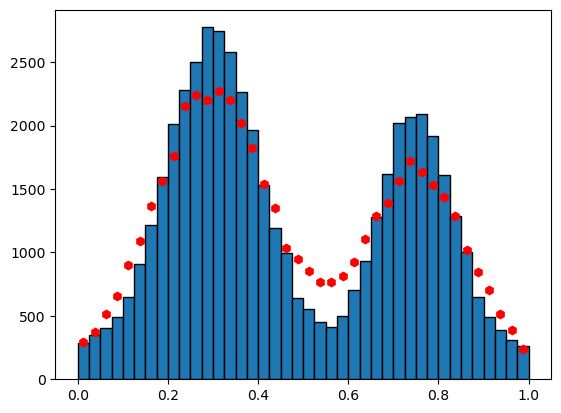

In [137]:
#plot true and reconstructed data
middlesM = np.linspace((1/(OBSERVED_BINS * 2)), (1 - 1/(OBSERVED_BINS * 2)), OBSERVED_BINS)
recon_binnedM, _ = np.histogram(recon_data, bins=OBSERVED_BINS, range=(0, 1))
true_hist = np.histogram(true_data_partial, bins=OBSERVED_BINS, range=(0, 1))[0]
plt.plot(middlesM, recon_binnedM, 'rh')
plt.hist(true_data_full, bins=OBSERVED_BINS, range=(0, 1), edgecolor = 'black')
plt.show()

In [138]:
#Compute A Matrix (M x N)
A = np.histogram2d(recon_data, true_data_partial, bins=(OBSERVED_BINS, UNFOLDED_BINS), range=((0, 1), (0, 1)))[0]

#Alternate Method
#A = np.zeros((OBSERVED_BINS, UNFOLDED_BINS))
# for real, recon in zip(true_data_partial, recon_data):
#     A[int(recon * OBSERVED_BINS)][int(real * UNFOLDED_BINS)] += 1

# Normalize by ful true data to account for acceptance losses
full_true_bins, _ = np.histogram(true_data_full, bins=UNFOLDED_BINS, range=(0, 1))
A = A / full_true_bins

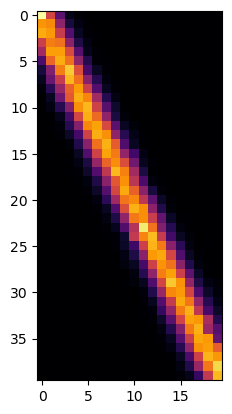

In [139]:
plt.imshow(A, cmap='inferno', interpolation='nearest')

In [140]:
def cal_llh(hist_1, hist_2):
    return (-2 * (np.sum(hist_1 * np.log(hist_2) - hist_2) - np.sum(hist_1 * np.log(hist_1) - hist_1)))
    
sampled_recon = [cal_llh(rng.poisson(recon_binnedM), recon_binnedM) for _ in range(100000)]

In [141]:
#Implementation of the R-L algorithm
unfolded = np.array([2500] * UNFOLDED_BINS) #starting with uniform dist
recon_binnedN, _ = np.histogram(recon_data, bins=OBSERVED_BINS, range=(0, 1))
#sum though all rows along the collumns
alpha = np.sum(A, axis=0)
print(alpha)

iter_count = 0
N_iter = np.matmul(A, unfolded)
llh = cal_llh(recon_binnedN, N_iter)
while llh > np.median(sampled_recon):
    d_k = np.matmul(A, unfolded)

    #plot it as it goes
    # x = np.linspace(0,1,OBSERVED_BINS)
    # plt.figure()
    # plt.scatter(x, d_k)
    # plt.scatter(x, recon_binnedN, color='red')

    ratio = recon_binnedN / (d_k + 1e-12)  # avoid division by zero
    unfolded = unfolded * (A.T @ ratio) / (alpha + 1e-12)

    N_iter = np.matmul(A, unfolded)
    llh = cal_llh(recon_binnedN, N_iter)
    iter_count += 1

for _ in range(10000000):
    d_k = np.matmul(A, unfolded)

    #plot it as it goes
    # x = np.linspace(0,1,OBSERVED_BINS)
    # plt.figure()
    # plt.scatter(x, d_k)
    # plt.scatter(x, recon_binnedN, color='red')

    ratio = recon_binnedN / (d_k + 1e-12)  # avoid division by zero
    unfolded = unfolded * (A.T @ ratio) / (alpha + 1e-12)
print(iter_count * 2)


[0.67249603 0.87695749 0.95964126 0.99395233 0.99953402 0.99981053
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         0.99925112 0.99274361 0.95896198
 0.84204545 0.67307692]
12


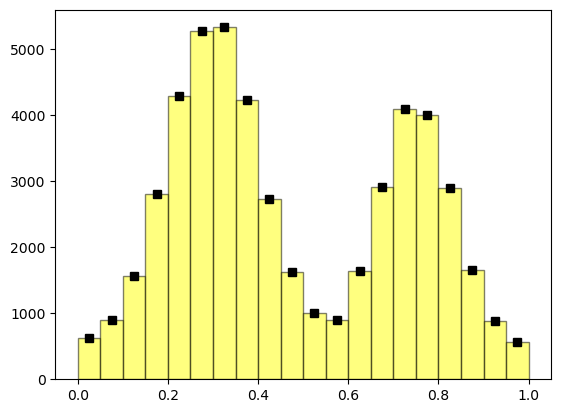

In [142]:
middlesN = np.linspace(start= (1 / (UNFOLDED_BINS * 2)), stop=1 - 1 / (UNFOLDED_BINS * 2), num=UNFOLDED_BINS)
plt.plot(middlesN, unfolded, 'ks')
plt.hist(true_data_full, bins=UNFOLDED_BINS, range=(0, 1), edgecolor = 'black', color='yellow', alpha=0.5)
plt.show()

27.850401466013864


Text(0, 0.5, 'llh')

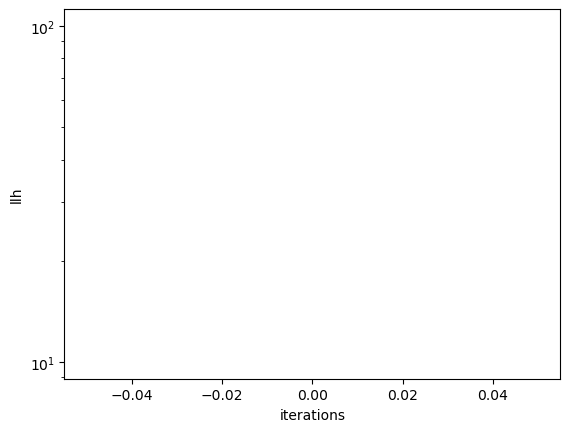

In [143]:
print(llh)
plt.plot(llh)
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('llh')